In [36]:
# ================================
# 0. SETUP & LOADING
# ================================
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.io as pio

from pathlib import Path

from scipy import stats
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import PowerTransformer

# phik for non-linear correlation (optional)
try:
    from phik import resources, report
    from phik.report import plot_correlation_matrix
    PHIK_AVAILABLE = True
except ImportError:
    PHIK_AVAILABLE = False
    print("phik not installed: skipping Phik correlation. `pip install phik` to enable.")

# Nice display settings
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)
sns.set(style="whitegrid", palette="colorblind")
pio.renderers.default = "notebook"  # or "browser" if you prefer

# ----------------
# Load processed data
# ----------------
DATA_DIR = Path(".")
train = pd.read_csv(DATA_DIR / "train_processed.csv")
test  = pd.read_csv(DATA_DIR / "test_processed.csv")

print("Train shape:", train.shape)
print("Test shape :", test.shape)

TARGET = "sii"  # inferred from your data
assert TARGET in train.columns, "Target column 'sii' not found in train_processed!"

y = train[TARGET]
X_train = train.drop(columns=[TARGET])
X_test  = test.copy()

# Identify dtypes
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

print(f"Numeric features: {len(num_cols)}")
print(f"Categorical features: {len(cat_cols)}")
print("First few numeric cols:", num_cols[:10])
print("Categorical cols:", cat_cols)


Train shape: (2736, 181)
Test shape : (20, 158)
Numeric features: 168
Categorical features: 12
First few numeric cols: ['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP']
Categorical cols: ['id', 'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season']


In [37]:
# ================================
# 1. BASIC STRUCTURE & MISSINGNESS
# ================================

print("\n=== TRAIN INFO ===")
display(train.head())
train.info()

print("\n=== TEST INFO ===")
display(test.head())
test.info()

print("\n=== Missingness in TRAIN (top 20) ===")
display(train.isna().mean().sort_values(ascending=False).head(20))

print("\n=== Missingness in TEST (top 20) ===")
display(test.isna().mean().sort_values(ascending=False).head(20))



=== TRAIN INFO ===


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,PCIAT-Season,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,sedentary_por,light_por,moderate_por,X_count,X_mean,X_std,X_min,X_25%,X_50%,X_75%,X_max,Y_count,Y_mean,Y_std,Y_min,Y_25%,Y_50%,Y_75%,Y_max,Z_count,Z_mean,Z_std,Z_min,Z_25%,Z_50%,Z_75%,Z_max,enmo_count,enmo_mean,enmo_std,enmo_min,enmo_25%,enmo_50%,enmo_75%,enmo_max,anglez_count,anglez_mean,anglez_std,anglez_min,anglez_25%,anglez_50%,anglez_75%,anglez_max,non-wear_flag_count,non-wear_flag_mean,non-wear_flag_std,non-wear_flag_min,non-wear_flag_25%,non-wear_flag_50%,non-wear_flag_75%,non-wear_flag_max,light_count,light_mean,light_std,light_min,light_25%,light_50%,light_75%,light_max,battery_voltage_count,battery_voltage_mean,battery_voltage_std,battery_voltage_min,battery_voltage_25%,battery_voltage_50%,battery_voltage_75%,battery_voltage_max,time_of_day_count,time_of_day_mean,time_of_day_std,time_of_day_min,time_of_day_25%,time_of_day_50%,time_of_day_75%,time_of_day_max,weekday_count,weekday_mean,weekday_std,weekday_min,weekday_25%,weekday_50%,weekday_75%,weekday_max,quarter_count,quarter_mean,quarter_std,quarter_min,quarter_25%,quarter_50%,quarter_75%,quarter_max,relative_date_PCIAT_count,relative_date_PCIAT_mean,relative_date_PCIAT_std,relative_date_PCIAT_min,relative_date_PCIAT_25%,relative_date_PCIAT_50%,relative_date_PCIAT_75%,relative_date_PCIAT_max
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,Fall,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55,NaN,NaN,NaN,Fall,3.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Fall,46.0,64.0,Summer,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Columns: 181 entries, id to relative_date_PCIAT_max
dtypes: float64(165), int64(4), object(12)
memory usage: 3.8+ MB

=== TEST INFO ===


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sedentary_por,light_por,moderate_por,X_count,X_mean,X_std,X_min,X_25%,X_50%,X_75%,X_max,Y_count,Y_mean,Y_std,Y_min,Y_25%,Y_50%,Y_75%,Y_max,Z_count,Z_mean,Z_std,Z_min,Z_25%,Z_50%,Z_75%,Z_max,enmo_count,enmo_mean,enmo_std,enmo_min,enmo_25%,enmo_50%,enmo_75%,enmo_max,anglez_count,anglez_mean,anglez_std,anglez_min,anglez_25%,anglez_50%,anglez_75%,anglez_max,non-wear_flag_count,non-wear_flag_mean,non-wear_flag_std,non-wear_flag_min,non-wear_flag_25%,non-wear_flag_50%,non-wear_flag_75%,non-wear_flag_max,light_count,light_mean,light_std,light_min,light_25%,light_50%,light_75%,light_max,battery_voltage_count,battery_voltage_mean,battery_voltage_std,battery_voltage_min,battery_voltage_25%,battery_voltage_50%,battery_voltage_75%,battery_voltage_max,time_of_day_count,time_of_day_mean,time_of_day_std,time_of_day_min,time_of_day_25%,time_of_day_50%,time_of_day_75%,time_of_day_max,weekday_count,weekday_mean,weekday_std,weekday_min,weekday_25%,weekday_50%,weekday_75%,weekday_max,quarter_count,quarter_mean,quarter_std,quarter_min,quarter_25%,quarter_50%,quarter_75%,quarter_max,relative_date_PCIAT_count,relative_date_PCIAT_mean,relative_date_PCIAT_std,relative_date_PCIAT_min,relative_date_PCIAT_25%,relative_date_PCIAT_50%,relative_date_PCIAT_75%,relative_date_PCIAT_max
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,Fall,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,Fall,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,Winter,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,Fall,5.0,7.0,33.0,Fall,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Columns: 158 entries, id to relative_date_PCIAT_max
dtypes: float64(145), int64(2), object(11)
memory usage: 24.8+ KB

=== Missingness in TRAIN (top 20) ===


PAQ_A-PAQ_A_Total               0.867325
PAQ_A-Season                    0.867325
Physical-Waist_Circumference    0.823465
Fitness_Endurance-Time_Mins     0.733918
Fitness_Endurance-Time_Sec      0.733918
Fitness_Endurance-Max_Stage     0.732822
FGC-FGC_GSND_Zone               0.684211
FGC-FGC_GSD_Zone                0.684211
FGC-FGC_GSD                     0.681652
FGC-FGC_GSND                    0.681287
light_50%                       0.635965
light_75%                       0.635965
light_max                       0.635965
battery_voltage_count           0.635965
battery_voltage_mean            0.635965
battery_voltage_std             0.635965
battery_voltage_min             0.635965
battery_voltage_25%             0.635965
enmo_max                        0.635965
enmo_50%                        0.635965
dtype: float64


=== Missingness in TEST (top 20) ===


PAQ_A-PAQ_A_Total    0.95
PAQ_A-Season         0.95
X_25%                0.90
X_50%                0.90
X_std                0.90
X_min                0.90
Y_count              0.90
Y_mean               0.90
Y_std                0.90
Y_min                0.90
Y_25%                0.90
Y_50%                0.90
X_75%                0.90
X_max                0.90
Z_count              0.90
Z_mean               0.90
Z_std                0.90
Z_min                0.90
Z_25%                0.90
Z_50%                0.90
dtype: float64

Found 22 PCIAT columns:
['PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total']
New train shape: (2736, 159)
New test shape : (20, 158)

=== Target summary (sii) ===


count    2736.000000
mean        0.580409
std         0.771122
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: sii, dtype: float64


Value counts (normalized):


sii
0    0.582602
1    0.266813
2    0.138158
3    0.012427
Name: proportion, dtype: float64

C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\1744274701.py:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




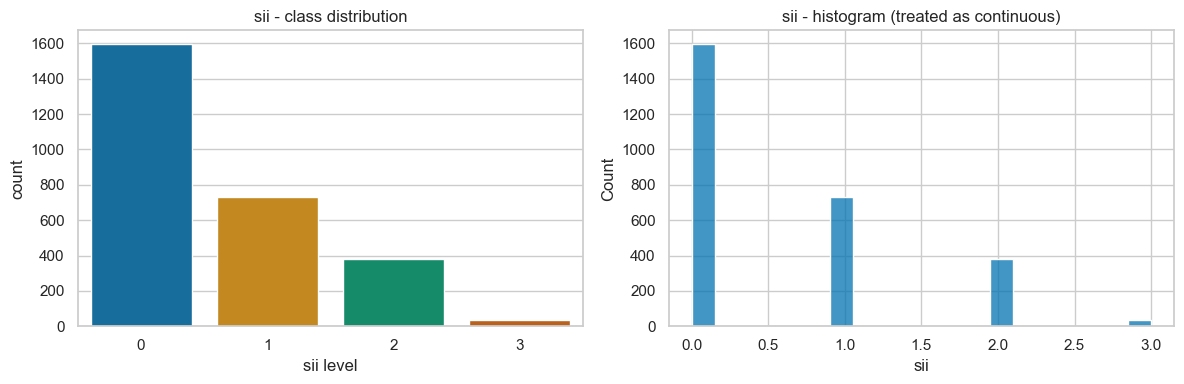

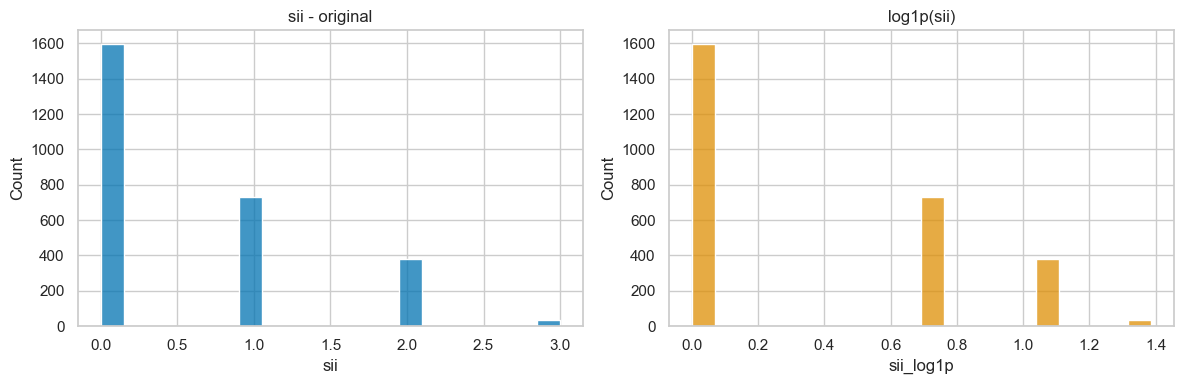

In [38]:
# ============================================================
# 0. Identify PCIAT columns
# ============================================================

pciat_cols = [c for c in train.columns if c.startswith("PCIAT-")]

print(f"Found {len(pciat_cols)} PCIAT columns:")
print(pciat_cols)

# ============================================================
# 1. Drop PCIAT columns directly in BOTH train and test
# ============================================================

train = train.drop(columns=pciat_cols, errors="ignore")
test  = test.drop(columns=pciat_cols, errors="ignore")

print("New train shape:", train.shape)
print("New test shape :", test.shape)


# ============================================================
# 2. TARGET VARIABLE EDA
# ============================================================

print("\n=== Target summary (sii) ===")
display(train[TARGET].describe())

print("\nValue counts (normalized):")
display(train[TARGET].value_counts(normalize=True).sort_index())

fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Raw class distribution
sns.countplot(
    x=TARGET, 
    data=train, 
    ax=axes[0], 
    palette="colorblind"
)
axes[0].set_title("sii - class distribution")
axes[0].set_xlabel("sii level")

# Histogram treating sii as continuous
sns.histplot(
    train[TARGET], 
    bins=20, 
    kde=False, 
    ax=axes[1], 
    color="C0"
)
axes[1].set_title("sii - histogram (treated as continuous)")

plt.tight_layout()
plt.show()

# Log transform (for regression modeling context)
train["sii_log1p"] = np.log1p(train[TARGET])

fig, ax = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(train[TARGET], bins=20, color="C0", ax=ax[0])
ax[0].set_title("sii - original")

sns.histplot(train["sii_log1p"], bins=20, color="C1", ax=ax[1])
ax[1].set_title("log1p(sii)")

plt.tight_layout()
plt.show()

# Clean temporary column
train.drop(columns=["sii_log1p"], inplace=True)


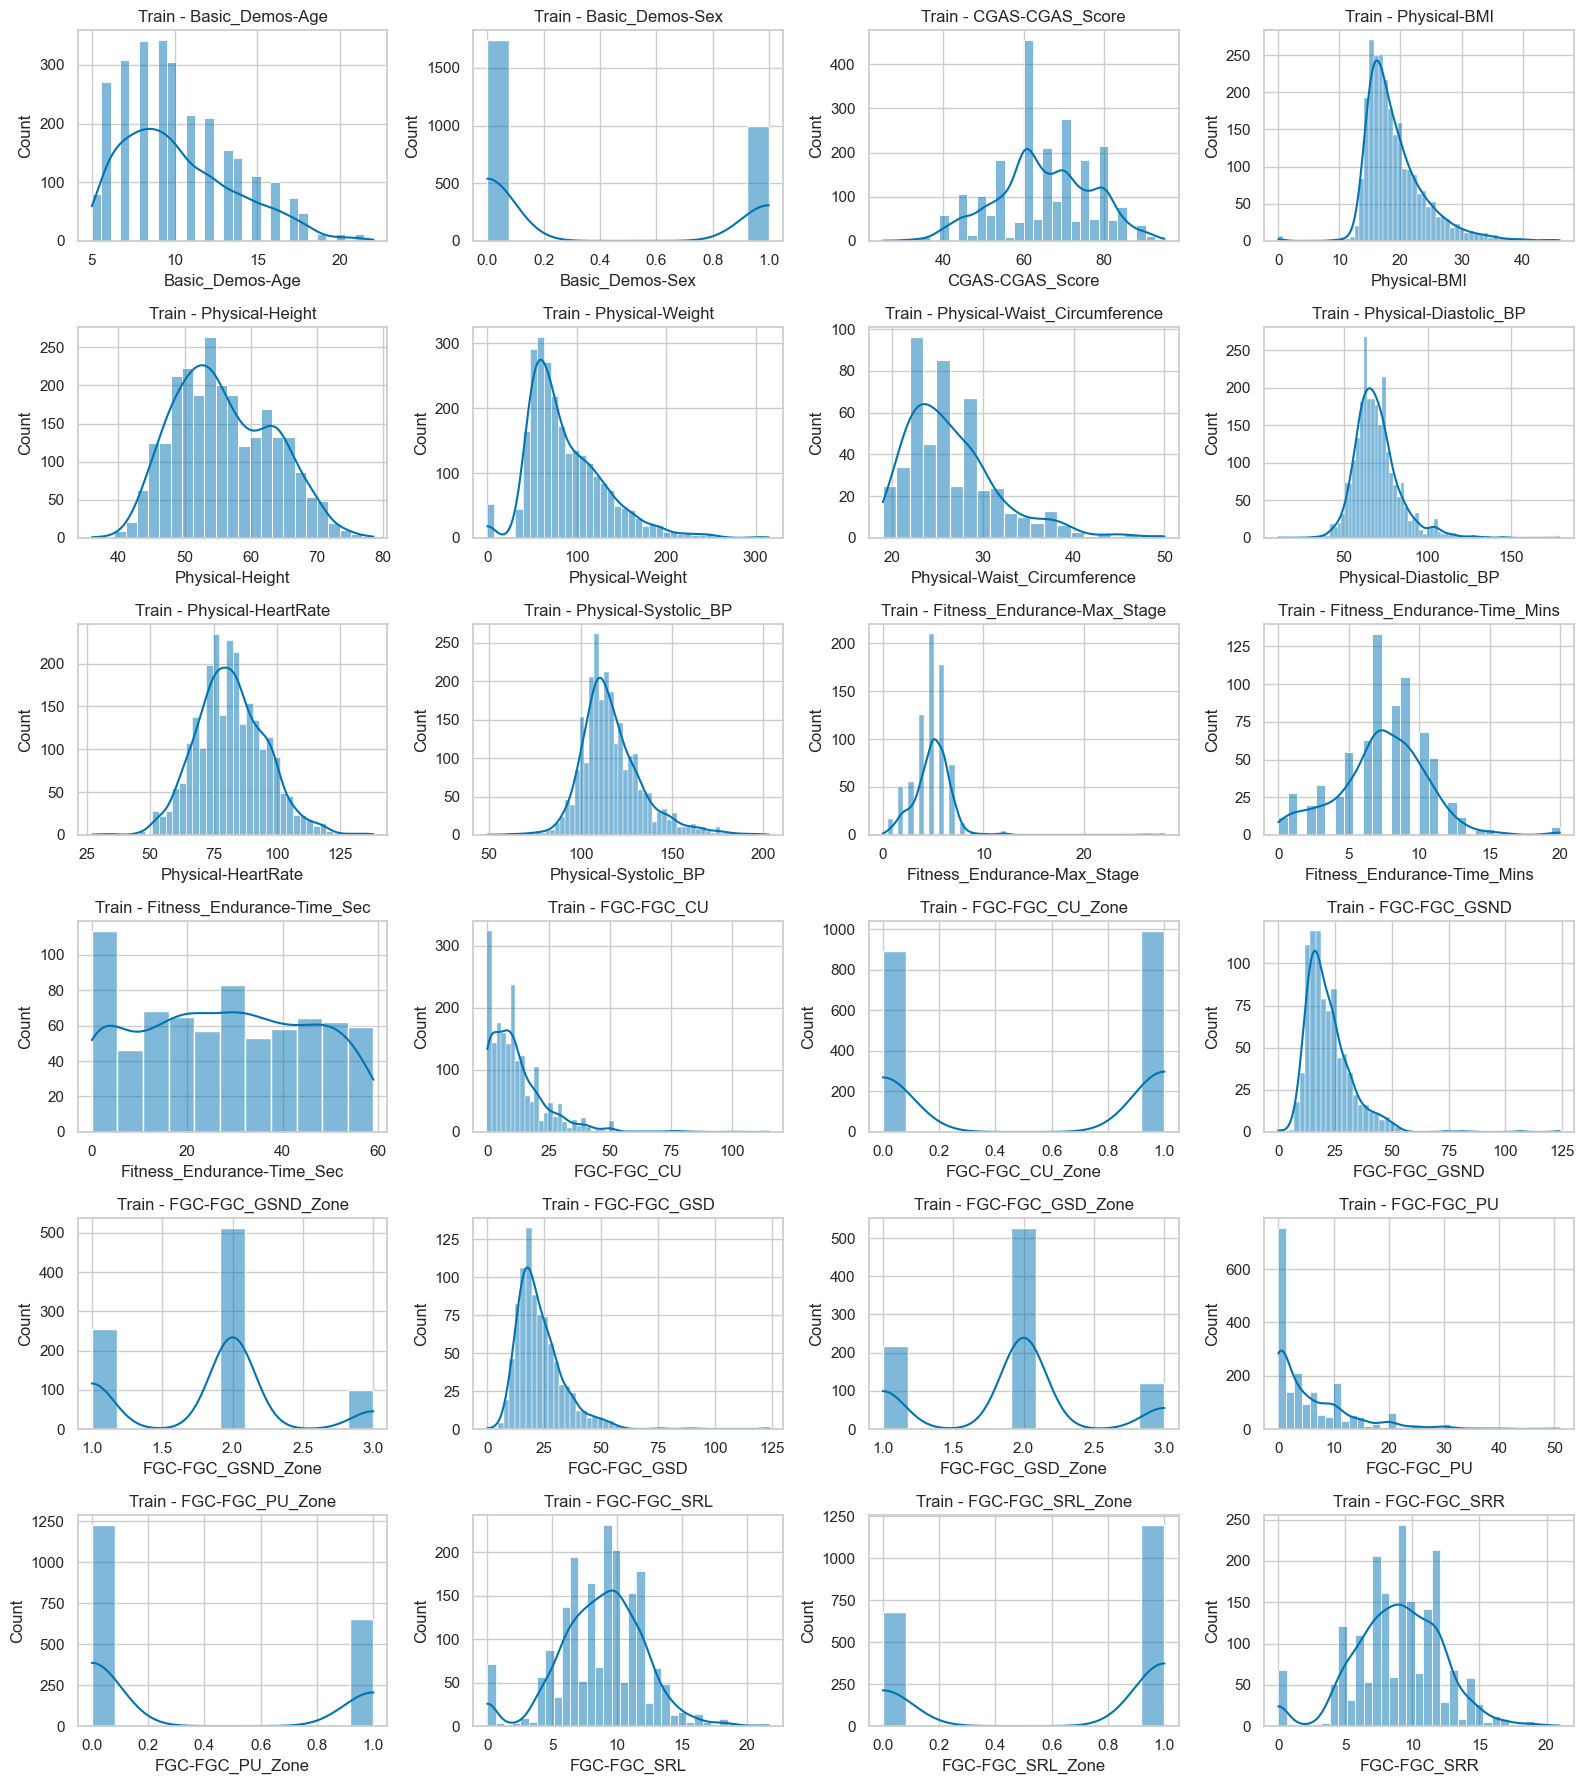

In [39]:
# ================================
# 3. DISTRIBUTION ANALYSIS (TRAIN)
# ================================

# For large number of features, you can subset or loop in batches
def plot_numeric_distributions(df, cols, n_cols=4, max_plots=24, title_prefix="Train"):
    cols = cols[:max_plots]
    n_features = len(cols)
    n_rows = int(np.ceil(n_features / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.histplot(df[col], kde=True, ax=axes[i], color="C0")
        axes[i].set_title(f"{title_prefix} - {col}")
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    plt.tight_layout()
    plt.show()

# Example: first 24 numeric features
plot_numeric_distributions(train, num_cols, n_cols=4, max_plots=24, title_prefix="Train")


Top 20 features by KS-stat (largest train-test distribution shift):


,feature,train_mean,test_mean,abs_mean_diff,ks_stat,ks_pvalue
43,PAQ_A-PAQ_A_Total,2.185758,1.040000,1.145758,0.961433,0.082418
57,X_75%,0.268717,-0.014879,0.283596,0.870482,0.034231
79,enmo_25%,0.003753,0.007527,0.003774,0.733936,0.142757
146,relative_date_PCIAT_max,78.834337,88.000000,9.165663,0.729920,0.147074
140,relative_date_PCIAT_mean,62.926103,66.318638,3.392535,0.676707,0.210355
142,relative_date_PCIAT_min,50.879518,54.500000,3.620482,0.661647,0.230314
53,X_std,0.473792,0.402605,0.071187,0.659639,0.233044
88,anglez_50%,-12.801342,-50.603268,37.801926,0.646586,0.251178
72,Z_50%,-0.178983,-0.626553,0.447570,0.644578,0.254029
144,relative_date_PCIAT_50%,62.691767,64.500000,1.808233,0.639558,0.261225


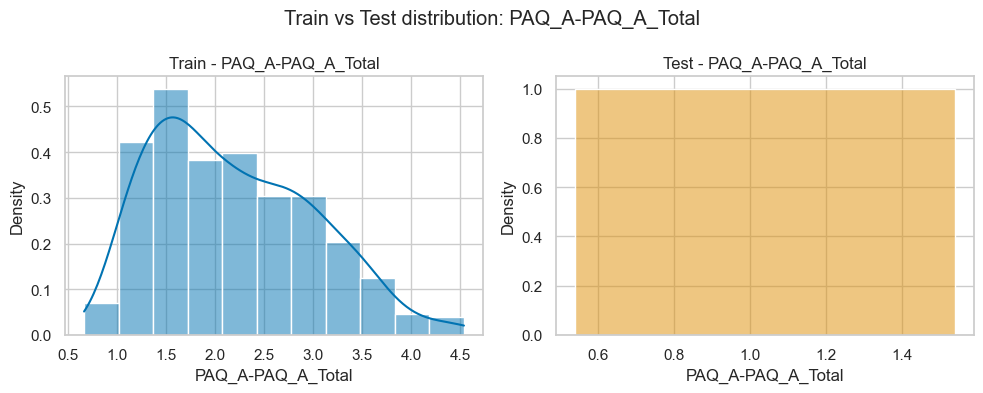

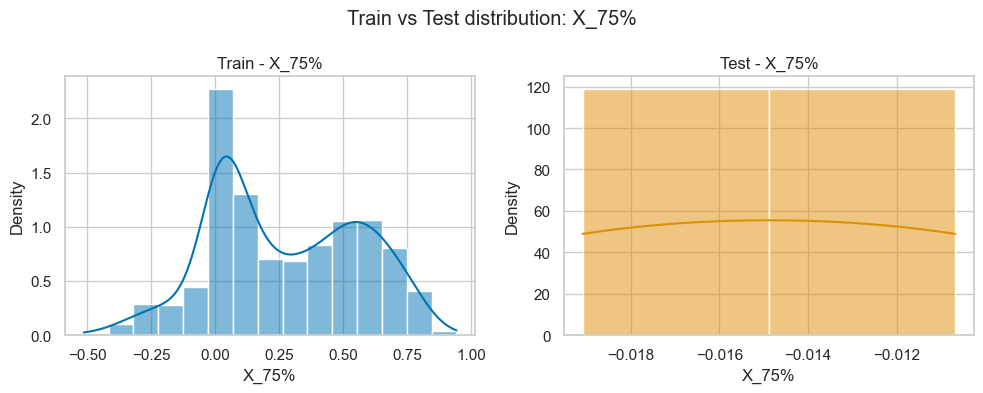

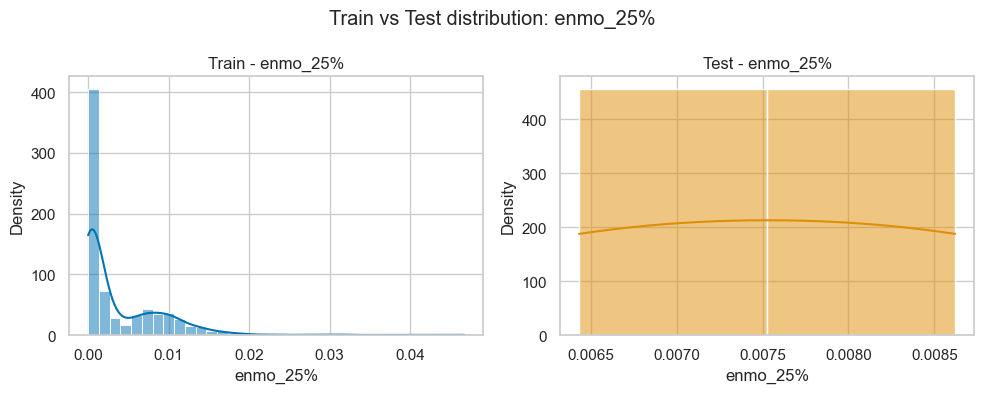

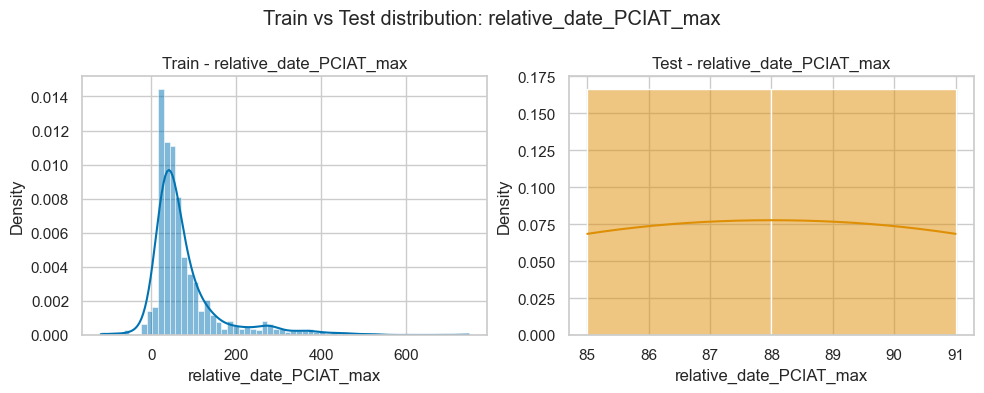

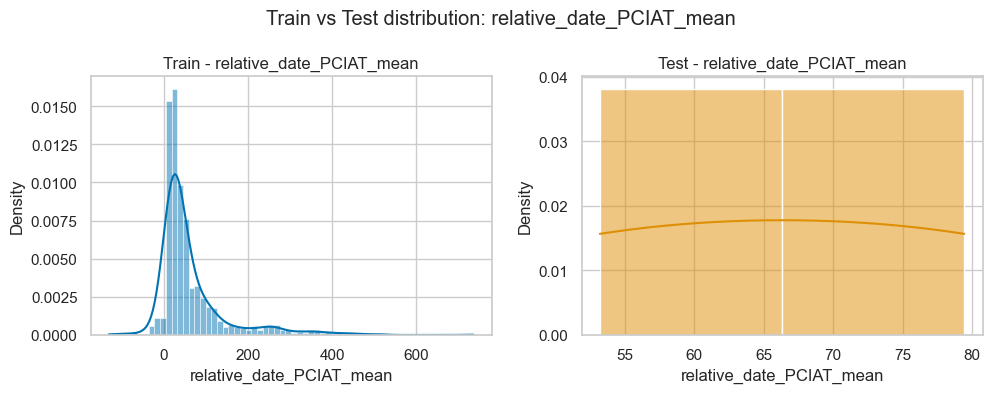

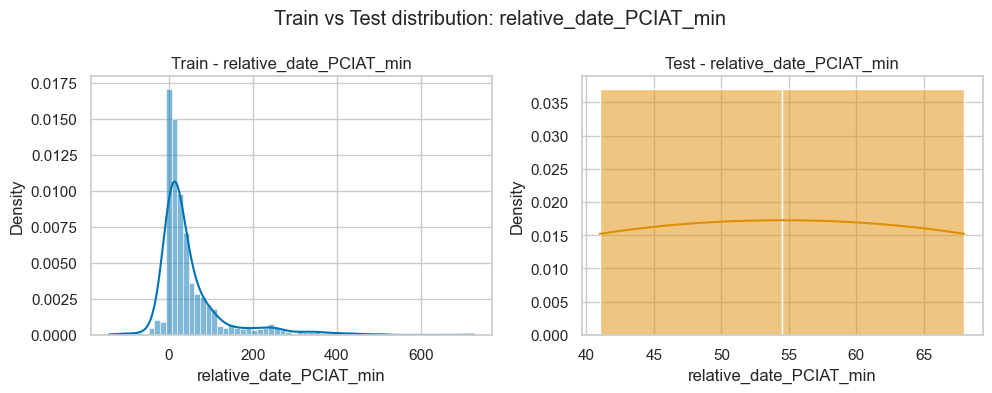

In [40]:
# ================================
# 4. TRAIN vs TEST DISTRIBUTION SHIFT
# ================================

from scipy.stats import ks_2samp

common_num = [c for c in num_cols if c in test.columns]

shift_records = []

for col in common_num:
    train_vals = train[col].dropna()
    test_vals  = test[col].dropna()
    if train_vals.empty or test_vals.empty:
        continue
    
    # KS test for distribution difference
    stat, pval = ks_2samp(train_vals, test_vals)
    
    shift_records.append({
        "feature": col,
        "train_mean": train_vals.mean(),
        "test_mean": test_vals.mean(),
        "abs_mean_diff": abs(train_vals.mean() - test_vals.mean()),
        "ks_stat": stat,
        "ks_pvalue": pval
    })

shift_df = pd.DataFrame(shift_records).sort_values("ks_stat", ascending=False)
print("Top 20 features by KS-stat (largest train-test distribution shift):")
display(shift_df.head(20))

# Plot a few of the highest-shift features
top_shift_feats = shift_df.head(6)["feature"].tolist()

for col in top_shift_feats:
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    
    sns.histplot(train[col], kde=True, ax=ax[0], color="C0", stat="density", common_norm=False)
    ax[0].set_title(f"Train - {col}")
    
    sns.histplot(test[col], kde=True, ax=ax[1], color="C1", stat="density", common_norm=False)
    ax[1].set_title(f"Test - {col}")
    
    plt.suptitle(f"Train vs Test distribution: {col}")
    plt.tight_layout()
    plt.show()


In [42]:
num_cols = train.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Remove target from numeric feature list if needed
if TARGET in num_cols:
    num_cols.remove(TARGET)

# Remove zero-variance columns (skew() crashes or returns NaN)
zero_var_cols = [c for c in num_cols if train[c].nunique() <= 1]
if zero_var_cols:
    print("Dropping zero-variance numeric columns:", zero_var_cols)
    num_cols = [c for c in num_cols if c not in zero_var_cols]

print(f"\nFinal numeric column count after PCIAT removal & validation: {len(num_cols)}")

Dropping zero-variance numeric columns: ['non-wear_flag_min', 'light_min']

Final numeric column count after PCIAT removal & validation: 145


In [43]:
# ================================
# 5. SKEWNESS & TRANSFORMATIONS
# ================================

skew_vals = train[num_cols].skew().sort_values(ascending=False)
print("Top 20 most positively skewed:")
display(skew_vals.head(20))

print("\nTop 20 most negatively skewed:")
display(skew_vals.tail(20))

high_skew_feats = skew_vals[skew_vals.abs() > 1].index.tolist()
print(f"\nNumeric features with |skew| > 1: {len(high_skew_feats)}")


Top 20 most positively skewed:


BIA-BIA_BMC                41.986709
BIA-BIA_LDM                40.987138
BIA-BIA_ECW                40.636668
BIA-BIA_FFM                40.410383
BIA-BIA_BMR                40.410378
BIA-BIA_TBW                39.981691
BIA-BIA_DEE                39.149979
BIA-BIA_ICW                38.828062
BIA-BIA_SMM                37.530942
BIA-BIA_LST                37.303175
BIA-BIA_FFMI               23.375478
battery_voltage_max        17.118375
light_25%                  15.295407
time_of_day_min            12.047049
weekday_min                11.072081
light_75%                   9.520083
anglez_min                  9.166540
light_50%                   8.463937
light_max                   7.177933
relative_date_PCIAT_std     3.932138
dtype: float64


Top 20 most negatively skewed:


non-wear_flag_count    -1.055599
anglez_count           -1.055599
weekday_count          -1.055599
Y_count                -1.055599
time_of_day_count      -1.055599
X_std                  -1.090158
time_of_day_std        -1.152972
FGC-FGC_TL_Zone        -1.304096
Y_std                  -1.401244
battery_voltage_std    -1.613736
weekday_mean           -1.971221
X_min                  -2.931947
weekday_75%            -3.439880
weekday_std            -3.829523
weekday_max            -8.242153
time_of_day_max       -12.729137
anglez_max            -15.892405
Z_min                 -15.903797
BIA-BIA_FMI           -16.858816
BIA-BIA_Fat           -40.901463
dtype: float64


Numeric features with |skew| > 1: 85


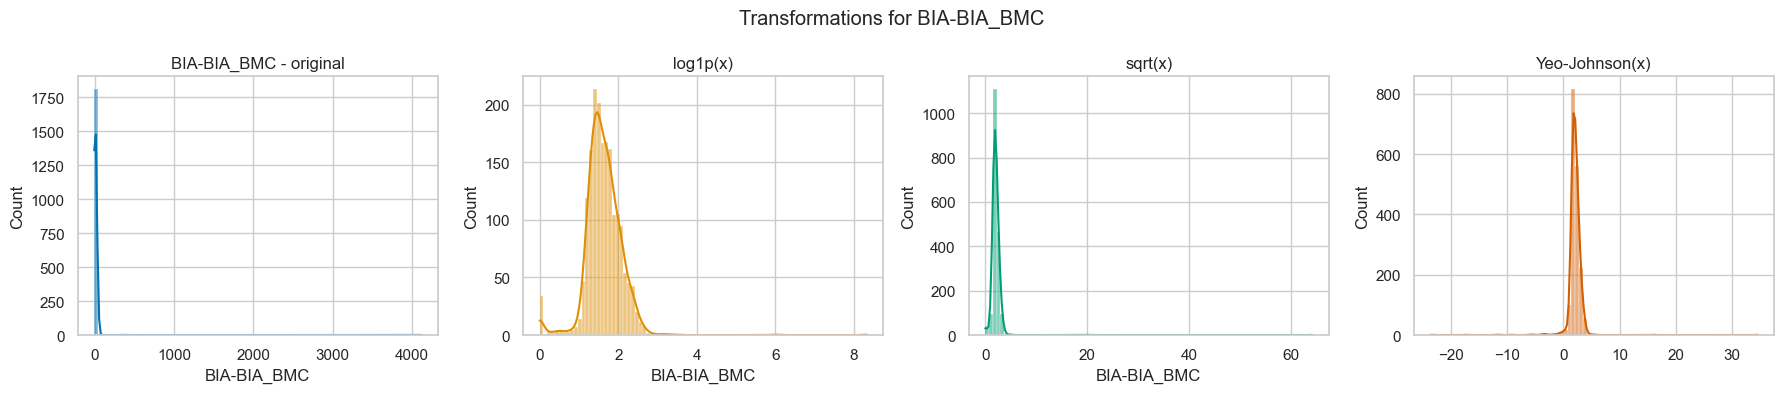

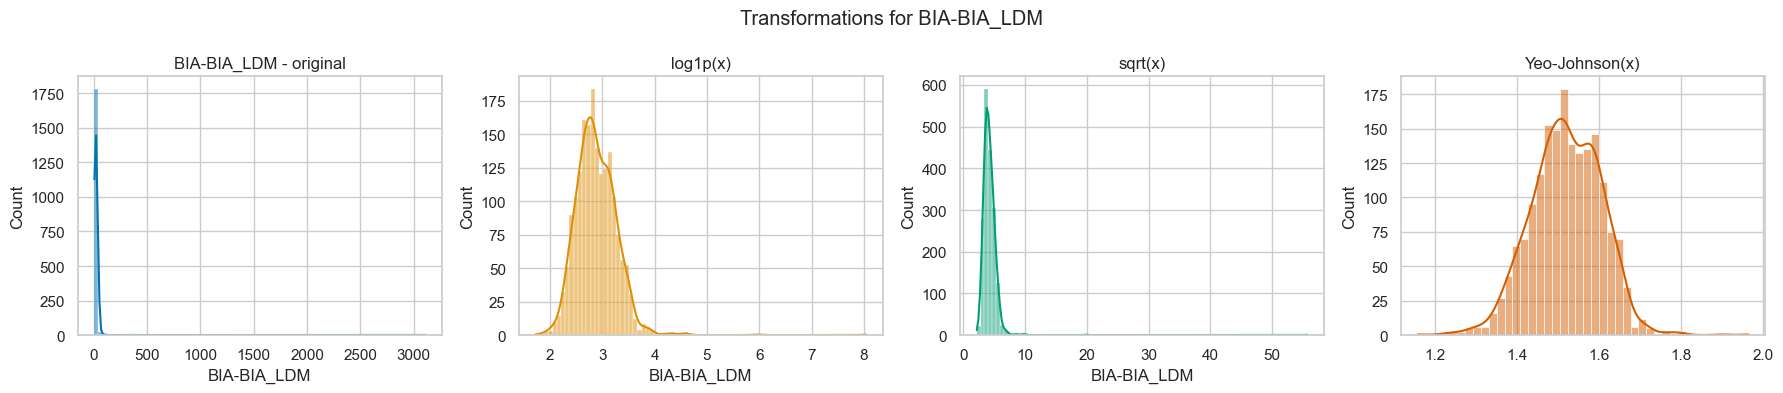

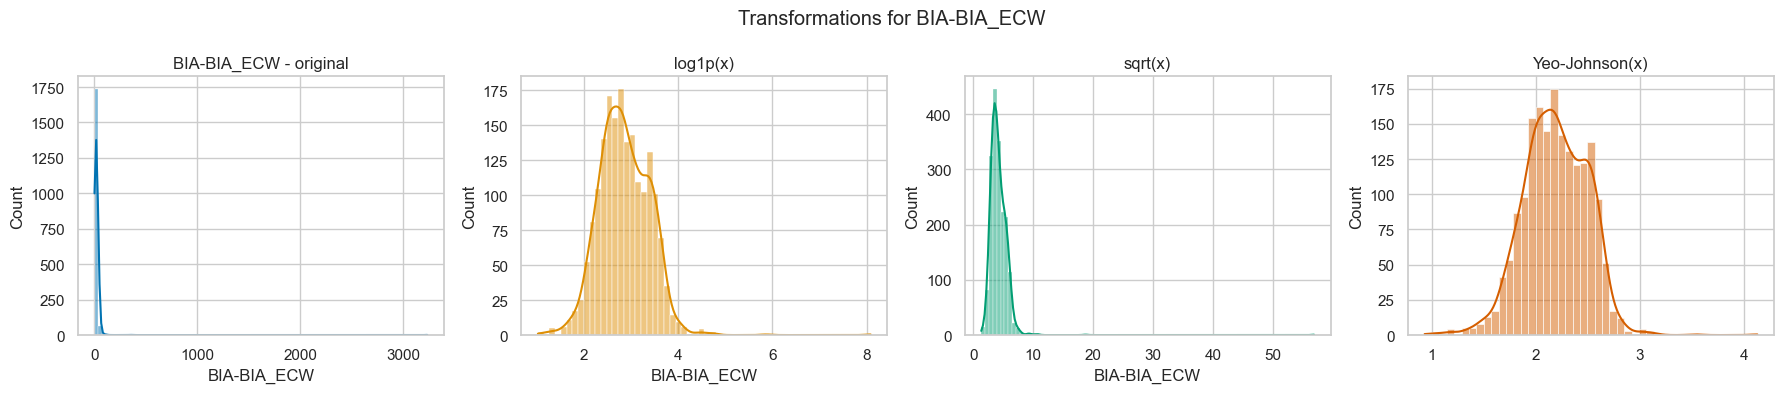

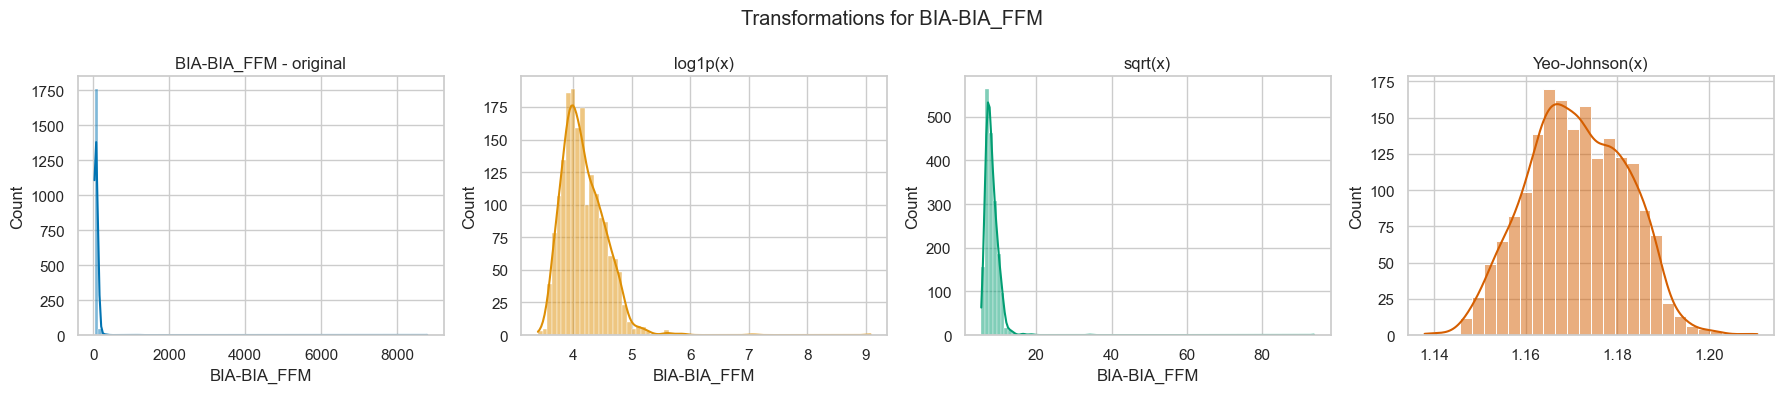

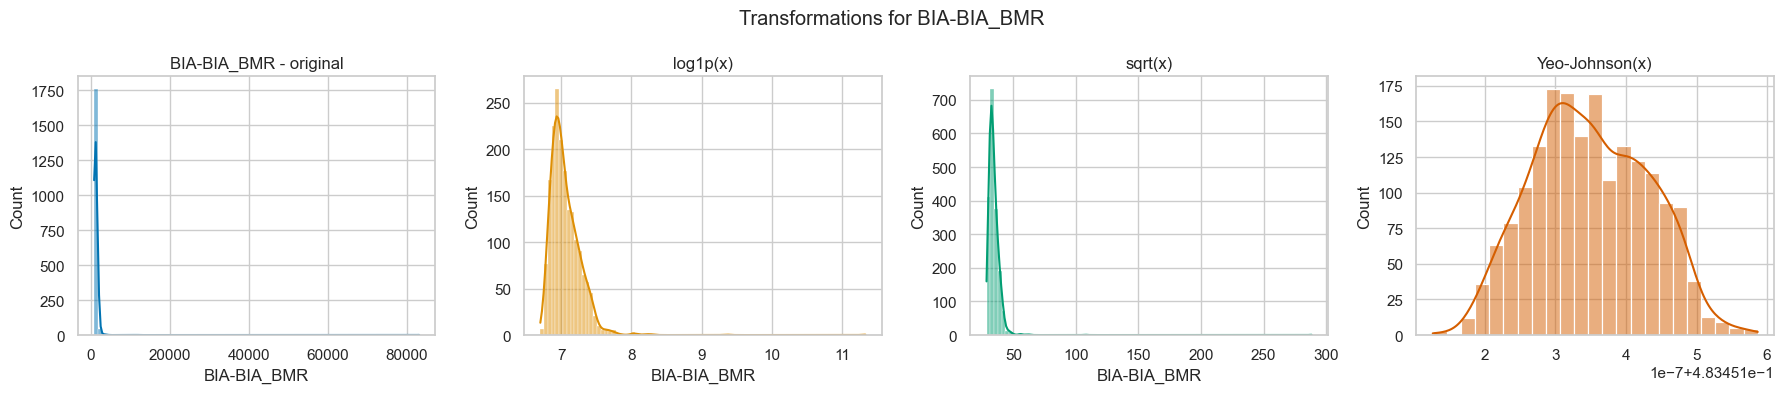

In [44]:
# Helper to visualize transformations
def plot_transform_effect(df, col, use_log=True, use_sqrt=True, use_yj=True):
    fig, axes = plt.subplots(1, 4, figsize=(18,4))
    sns.histplot(df[col], kde=True, ax=axes[0], color="C0")
    axes[0].set_title(f"{col} - original")

    if use_log:
        x = df[col].copy()
        x = np.log1p(np.clip(x, a_min=0, a_max=None))
        sns.histplot(x, kde=True, ax=axes[1], color="C1")
        axes[1].set_title("log1p(x)")

    if use_sqrt:
        x2 = df[col].copy()
        x2 = np.sqrt(np.clip(x2, a_min=0, a_max=None))
        sns.histplot(x2, kde=True, ax=axes[2], color="C2")
        axes[2].set_title("sqrt(x)")

    if use_yj:
        x3 = df[[col]].copy().dropna()
        pt = PowerTransformer(method="yeo-johnson", standardize=False)
        x3_t = pt.fit_transform(x3)
        sns.histplot(x3_t[:,0], kde=True, ax=axes[3], color="C3")
        axes[3].set_title("Yeo-Johnson(x)")
    
    plt.suptitle(f"Transformations for {col}")
    plt.tight_layout()
    plt.show()

# Example: pick a few representative skewed features
example_skew_feats = high_skew_feats[:5]
for c in example_skew_feats:
    plot_transform_effect(train, c)


In [45]:
# ===============================
# 0. Identify PCIAT columns
# ===============================
pciat_cols = [c for c in train.columns if c.startswith("PCIAT-")]

# ===============================
# 1. Compute skewness
# ===============================
skew_vals = train[num_cols].skew().sort_values(ascending=False)

high_pos_skew = [c for c in skew_vals.index if skew_vals[c] > 1]
high_neg_skew = [c for c in skew_vals.index if skew_vals[c] < -1]

# Exclude PCIAT columns from transformation decision
high_pos_skew = [c for c in high_pos_skew if c not in pciat_cols]
high_neg_skew = [c for c in high_neg_skew if c not in pciat_cols]

high_skew_feats = high_pos_skew + high_neg_skew

# ===============================
# 2. Transformation buckets
# ===============================
log_candidates = [
    c for c in high_pos_skew 
    if (train[c].min() >= 0) and (c not in pciat_cols)
]

yj_candidates = [
    c for c in high_skew_feats 
    if (c not in log_candidates) and (c not in pciat_cols)
]

print("Log1p candidates (>=0, PCIAT excluded):", log_candidates[:10])
print("Yeo-Johnson candidates (PCIAT excluded):", yj_candidates[:10])

# ===============================
# 3. Apply transformations
# ===============================
train_tf = train.copy()
test_tf  = test.copy()

# ----------- LOG1P ---------------
for c in log_candidates:
    # safe: train-only fit via simple transform
    train_tf[c + "_log1p"] = np.log1p(np.clip(train_tf[c], 0, None))
    test_tf[c + "_log1p"]  = np.log1p(np.clip(test_tf[c],  0, None))

# ----------- YEO


Log1p candidates (>=0, PCIAT excluded): ['BIA-BIA_LDM', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_BMR', 'BIA-BIA_TBW', 'BIA-BIA_DEE', 'BIA-BIA_ICW', 'BIA-BIA_SMM', 'BIA-BIA_LST', 'BIA-BIA_FFMI']
Yeo-Johnson candidates (PCIAT excluded): ['BIA-BIA_BMC', 'anglez_min', 'relative_date_PCIAT_min', 'relative_date_PCIAT_25%', 'relative_date_PCIAT_mean', 'relative_date_PCIAT_50%', 'relative_date_PCIAT_75%', 'relative_date_PCIAT_max', 'Z_25%', 'Y_50%']


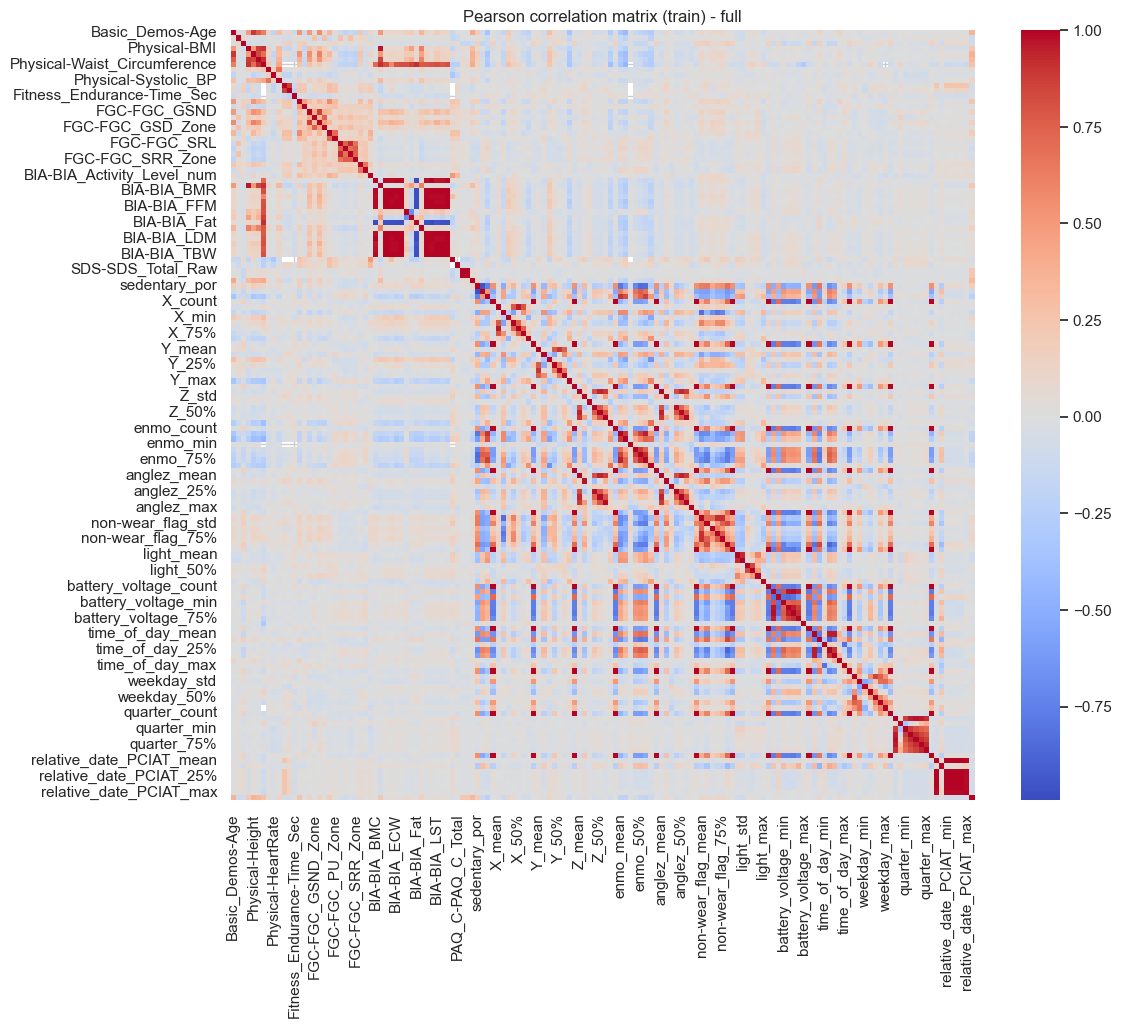

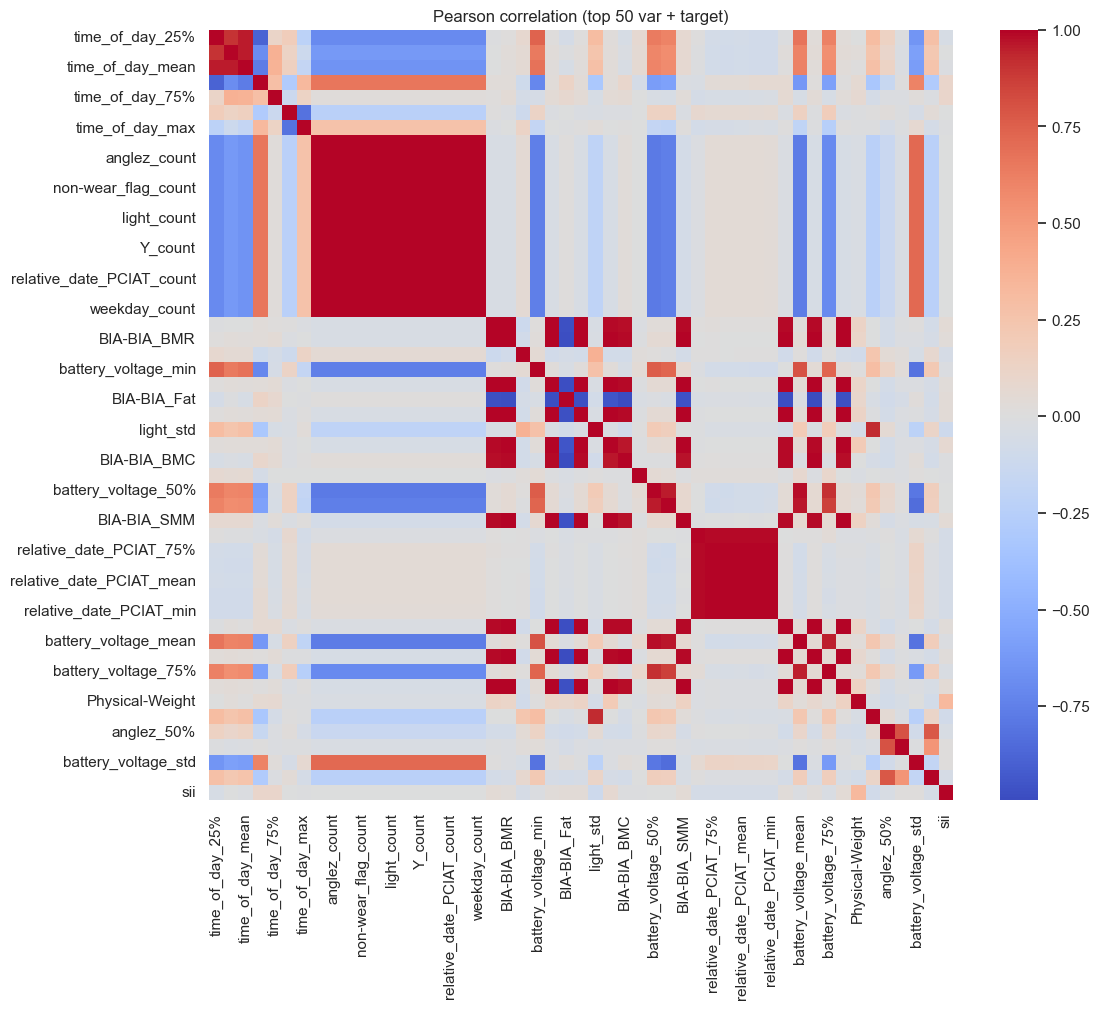

In [46]:
# ================================
# 6. CORRELATION ANALYSIS
# ================================

# Pearson
corr_pearson = train[num_cols + [TARGET]].corr(method="pearson")
corr_spearman = train[num_cols + [TARGET]].corr(method="spearman")

# Heatmaps (downsample to avoid unreadable walls)
plt.figure(figsize=(12,10))
sns.heatmap(corr_pearson, cmap="coolwarm", center=0)
plt.title("Pearson correlation matrix (train) - full")
plt.show()

# Often more readable: only top 50 numeric features by variance or MI
top_var_cols = train[num_cols].var().sort_values(ascending=False).head(50).index.tolist()
plt.figure(figsize=(12,10))
sns.heatmap(train[top_var_cols + [TARGET]].corr(), cmap="coolwarm", center=0)
plt.title("Pearson correlation (top 50 var + target)")
plt.show()


In [47]:
corr_with_target = train[num_cols + [TARGET]].corr()[TARGET].drop(TARGET).sort_values(ascending=False)
print("Top 20 positively correlated with sii (Pearson):")
display(corr_with_target.head(20))

print("\nTop 20 negatively correlated with sii (Pearson):")
display(corr_with_target.tail(20))


Top 20 positively correlated with sii (Pearson):


Physical-Height                           0.373530
Basic_Demos-Age                           0.365990
PreInt_EduHx-computerinternet_hoursday    0.336526
Physical-Weight                           0.325938
Physical-Waist_Circumference              0.272885
FGC-FGC_CU                                0.247364
SDS-SDS_Total_T                           0.232982
SDS-SDS_Total_Raw                         0.229692
BIA-BIA_BMI                               0.227818
Physical-BMI                              0.221125
FGC-FGC_PU                                0.177125
sedentary_por                             0.169837
BIA-BIA_Frame_num                         0.165936
FGC-FGC_GSD                               0.163448
FGC-FGC_GSND                              0.149495
Physical-Systolic_BP                      0.135336
Y_min                                     0.124462
non-wear_flag_mean                        0.116949
X_min                                     0.116040
non-wear_flag_75%              


Top 20 negatively correlated with sii (Pearson):


FGC-FGC_SRR_Zone              -0.068528
Fitness_Endurance-Max_Stage   -0.070589
Z_max                         -0.081187
light_mean                    -0.083179
CGAS-CGAS_Score               -0.085261
X_75%                         -0.088184
X_max                         -0.088749
enmo_25%                      -0.097237
Basic_Demos-Sex               -0.100148
FGC-FGC_SRL_Zone              -0.112497
light_std                     -0.112711
light_por                     -0.120222
enmo_max                      -0.122360
X_std                         -0.131707
Y_max                         -0.140232
enmo_50%                      -0.155682
enmo_75%                      -0.184841
enmo_mean                     -0.205348
enmo_std                      -0.208141
moderate_por                  -0.227077
Name: sii, dtype: float64

In [48]:
# Mutual information (nonlinear dependency measure)
X_num = train[num_cols].fillna(0)
mi = mutual_info_regression(X_num, train[TARGET], random_state=42)
mi_series = pd.Series(mi, index=num_cols).sort_values(ascending=False)

print("Top 20 features by Mutual Information with sii:")
display(mi_series.head(20))


Top 20 features by Mutual Information with sii:


Physical-Height                           0.083987
PreInt_EduHx-computerinternet_hoursday    0.083929
Basic_Demos-Age                           0.078389
Physical-Weight                           0.073614
BIA-BIA_ICW                               0.073454
BIA-BIA_LDM                               0.063550
BIA-BIA_ECW                               0.048673
FGC-FGC_GSND                              0.048255
BIA-BIA_FFM                               0.046561
FGC-FGC_GSD_Zone                          0.046261
BIA-BIA_TBW                               0.045409
BIA-BIA_DEE                               0.043214
Physical-Diastolic_BP                     0.042047
BIA-BIA_BMR                               0.041422
BIA-BIA_SMM                               0.036113
Physical-BMI                              0.035880
Fitness_Endurance-Time_Mins               0.033656
SDS-SDS_Total_Raw                         0.032182
Y_25%                                     0.032086
PAQ_A-PAQ_A_Total              

In [56]:
# Identify highly correlated numeric pairs
corr_num = train[num_cols].corr()
high_corr_pairs = []
threshold = 0.9

for i, c1 in enumerate(num_cols):
    for c2 in num_cols[i+1:]:
        val = corr_num.loc[c1, c2]
        if abs(val) >= threshold:
            high_corr_pairs.append((c1, c2, val))

print(f"Highly correlated pairs (|r| >= {threshold}): {len(high_corr_pairs)}")
display(pd.DataFrame(high_corr_pairs, columns=["feat1","feat2","corr"]).head(30))


Highly correlated pairs (|r| >= 0.9): 174


,feat1,feat2,corr
0,Physical-BMI,Physical-Waist_Circumference,0.903291
1,Physical-BMI,BIA-BIA_BMI,0.964411
2,Physical-Weight,Physical-Waist_Circumference,0.913993
3,Physical-Waist_Circumference,BIA-BIA_BMI,0.913400
4,Physical-Waist_Circumference,BIA-BIA_Fat,0.914659
5,FGC-FGC_SRL,FGC-FGC_SRR,0.914685
6,BIA-BIA_BMC,BIA-BIA_BMR,0.990015
7,BIA-BIA_BMC,BIA-BIA_DEE,0.979736
8,BIA-BIA_BMC,BIA-BIA_ECW,0.989881
9,BIA-BIA_BMC,BIA-BIA_FFM,0.990015


C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\3155537842.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\3155537842.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




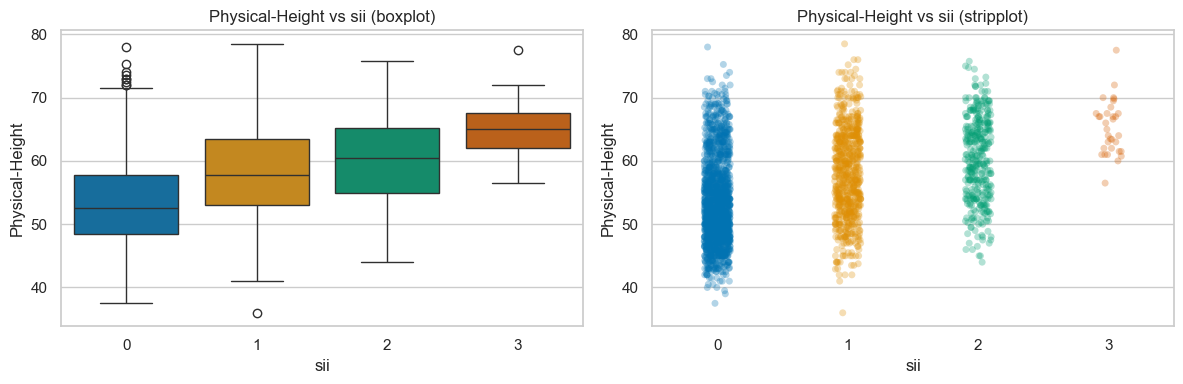

C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\3155537842.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\3155537842.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




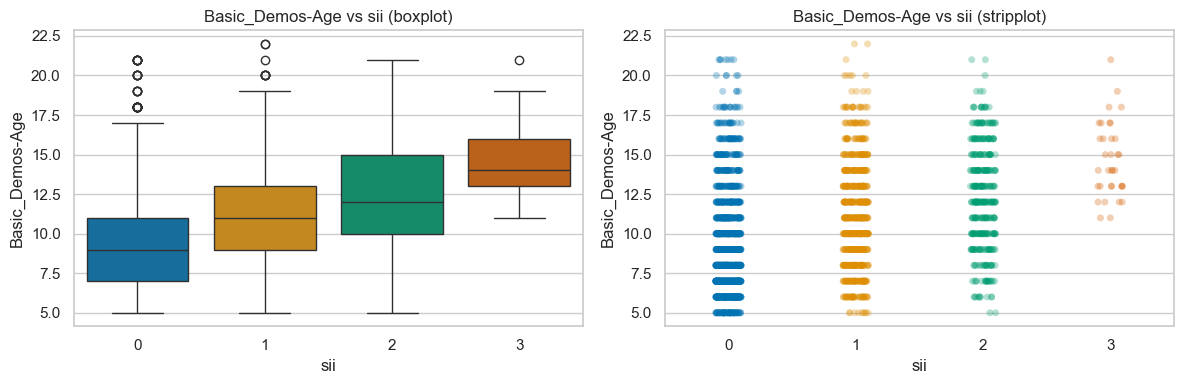

C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\3155537842.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\3155537842.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




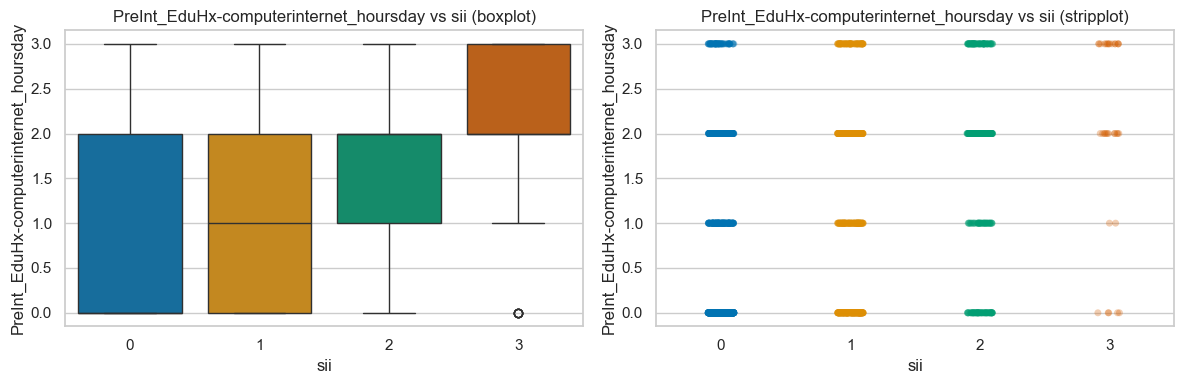

C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\3155537842.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\3155537842.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




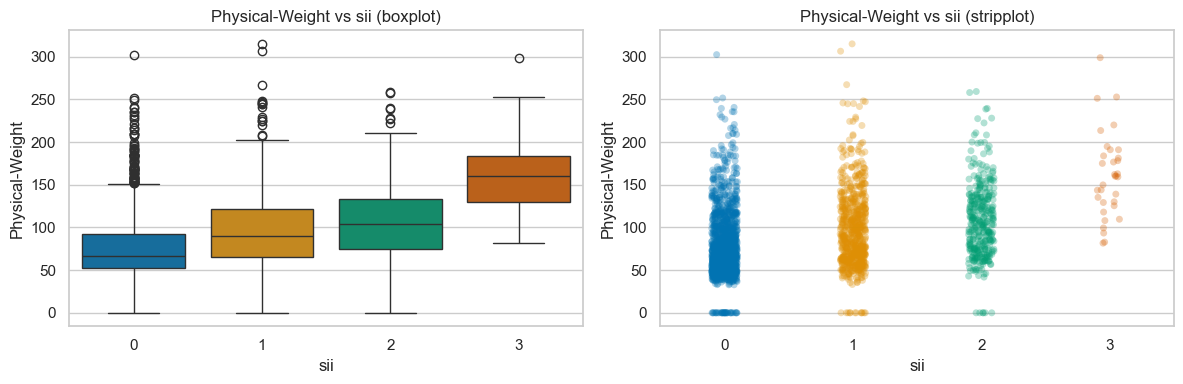

C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\3155537842.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\3155537842.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




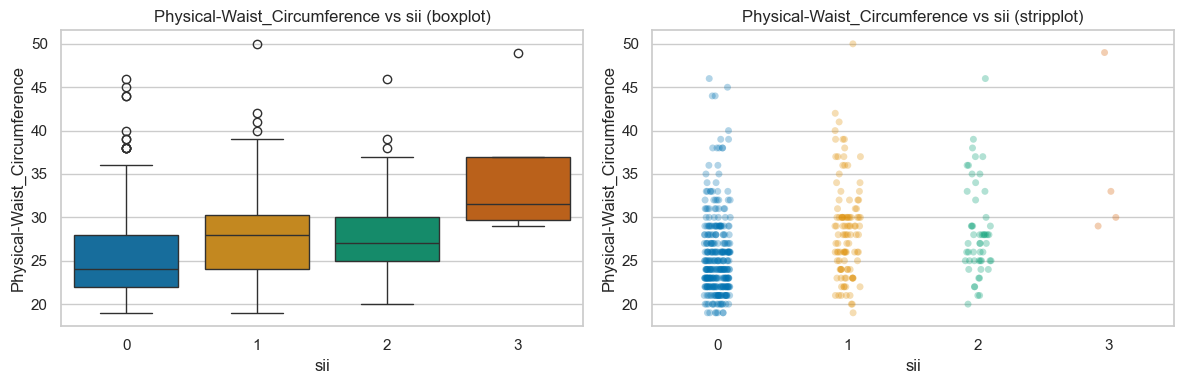

C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\3155537842.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\3155537842.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




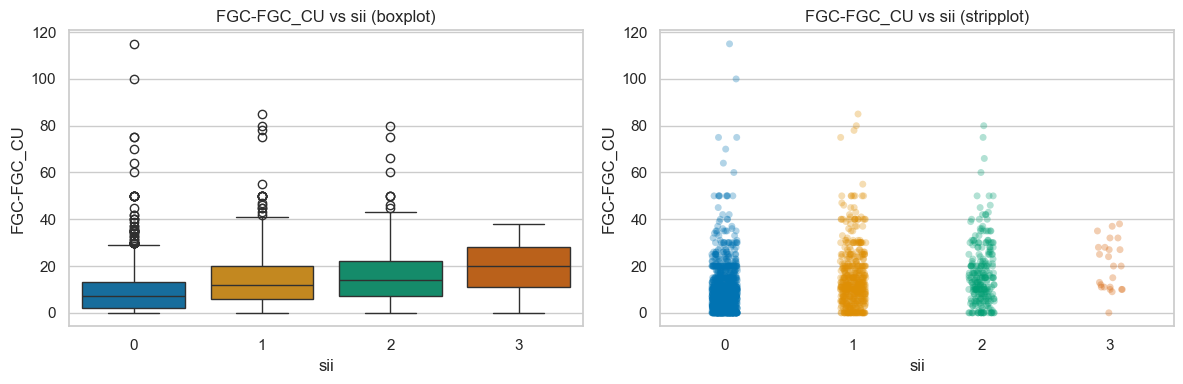

In [57]:
# ================================
# 7. TARGET vs TOP FEATURES
# ================================

top_corr_feats = corr_with_target.head(10).index.tolist()
top_neg_feats = corr_with_target.tail(10).index.tolist()

# Scatter / strip plots for a subset
for col in top_corr_feats[:6]:
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    
    sns.boxplot(x=TARGET, y=col, data=train, ax=axes[0], palette="colorblind")
    axes[0].set_title(f"{col} vs sii (boxplot)")
    
    sns.stripplot(x=TARGET, y=col, data=train, ax=axes[1], palette="colorblind", alpha=0.3)
    axes[1].set_title(f"{col} vs sii (stripplot)")
    
    plt.tight_layout()
    plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\2086622580.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\2086622580.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




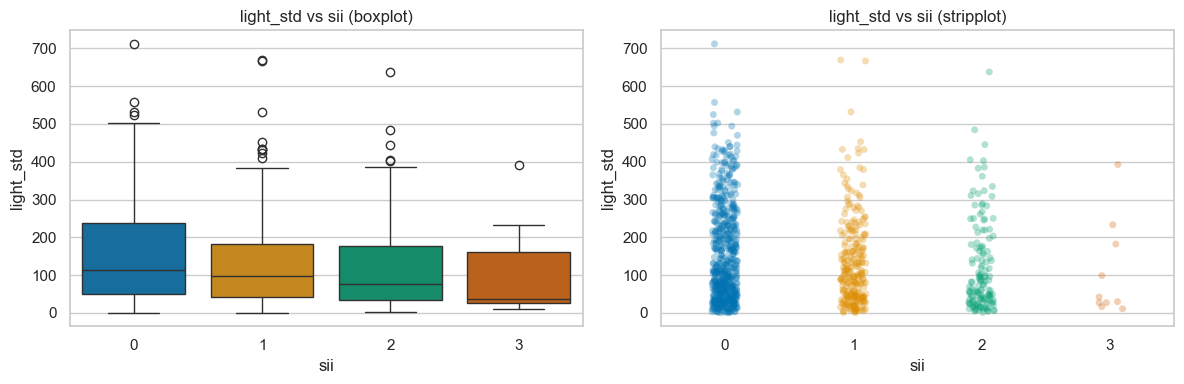

C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\2086622580.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\2086622580.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




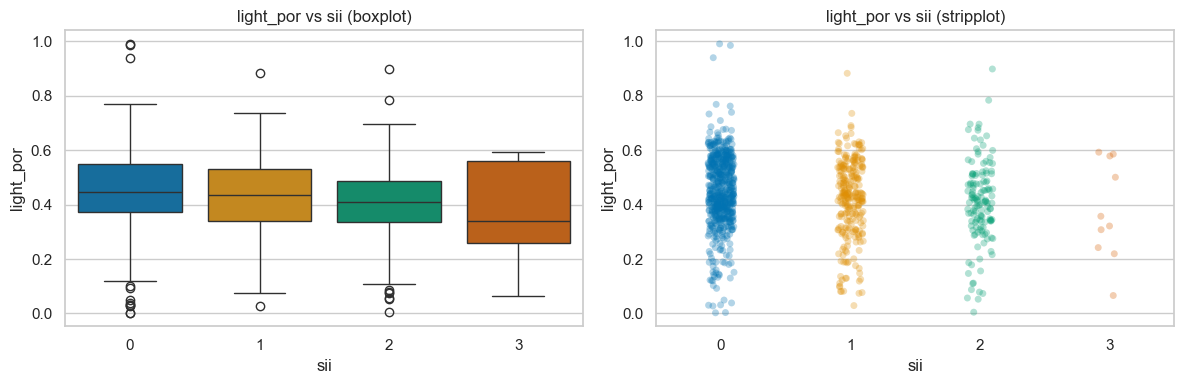

C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\2086622580.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\2086622580.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




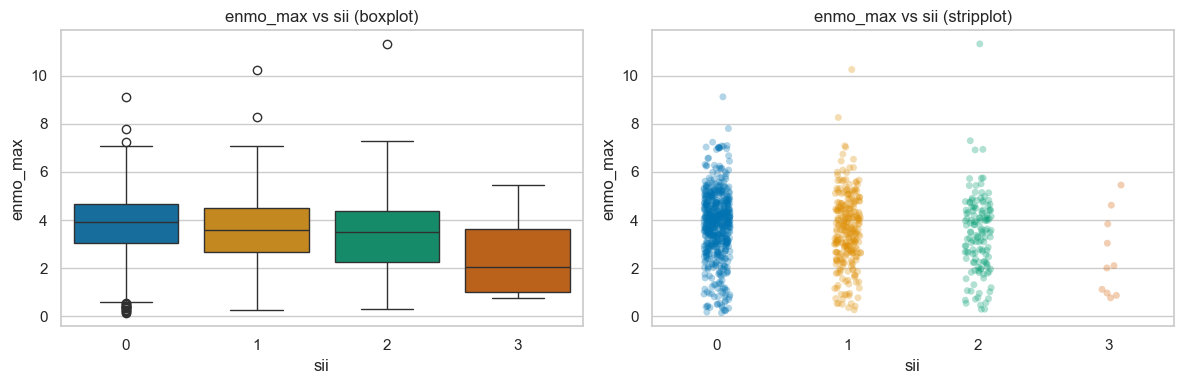

C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\2086622580.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\2086622580.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




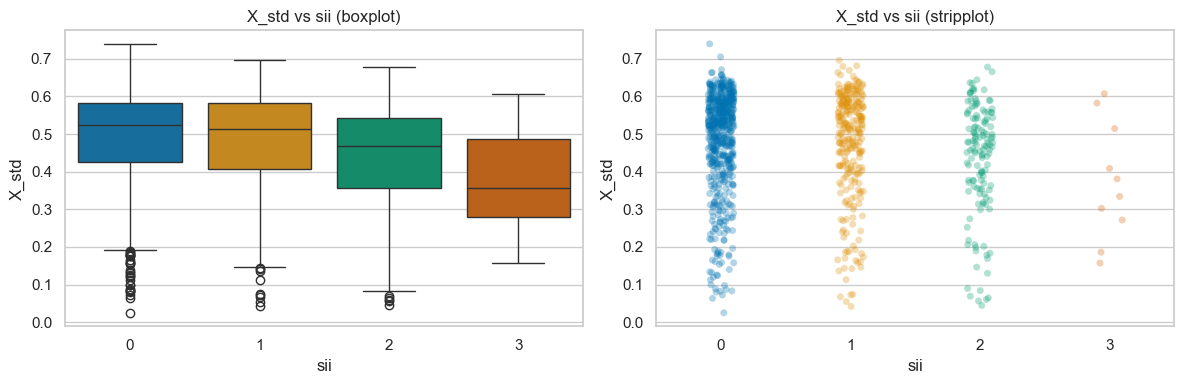

C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\2086622580.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\2086622580.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




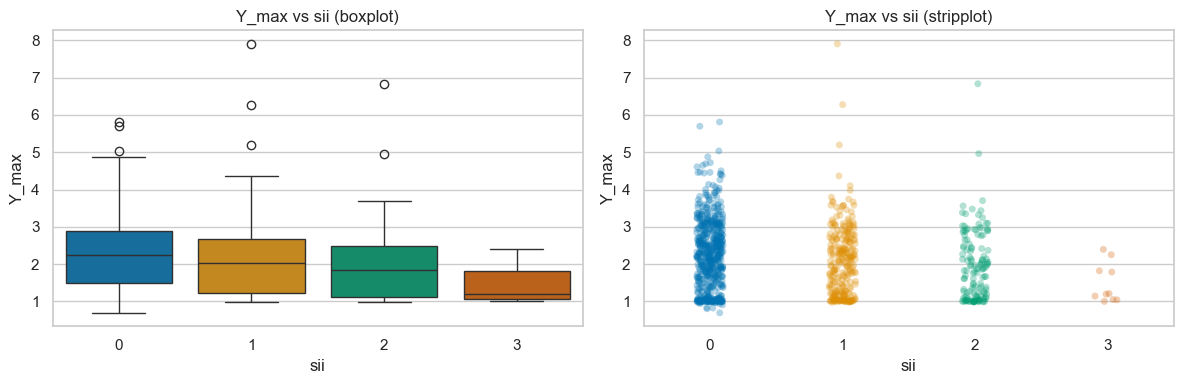

C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\2086622580.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\2086622580.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




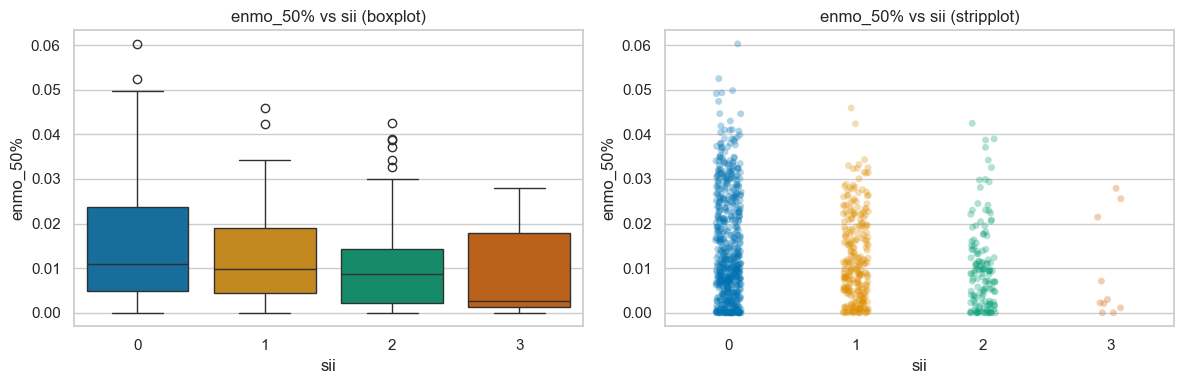

C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\2086622580.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\2086622580.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




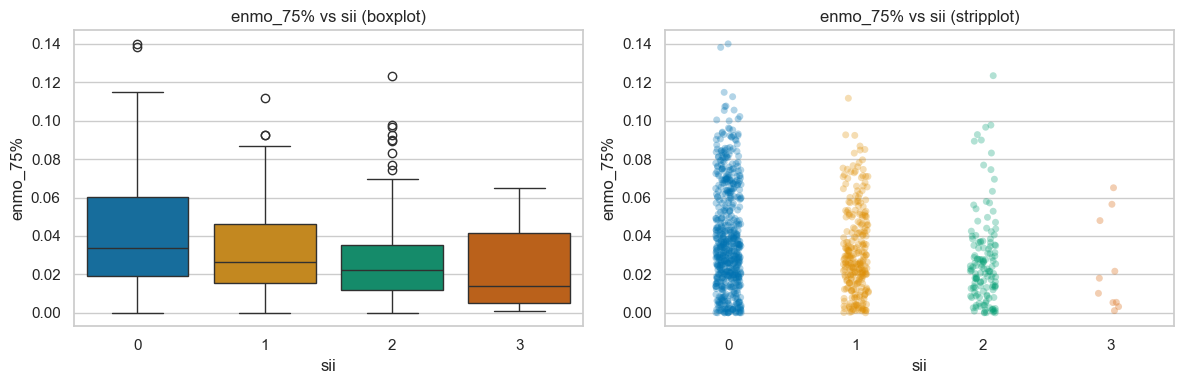

C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\2086622580.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\2086622580.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




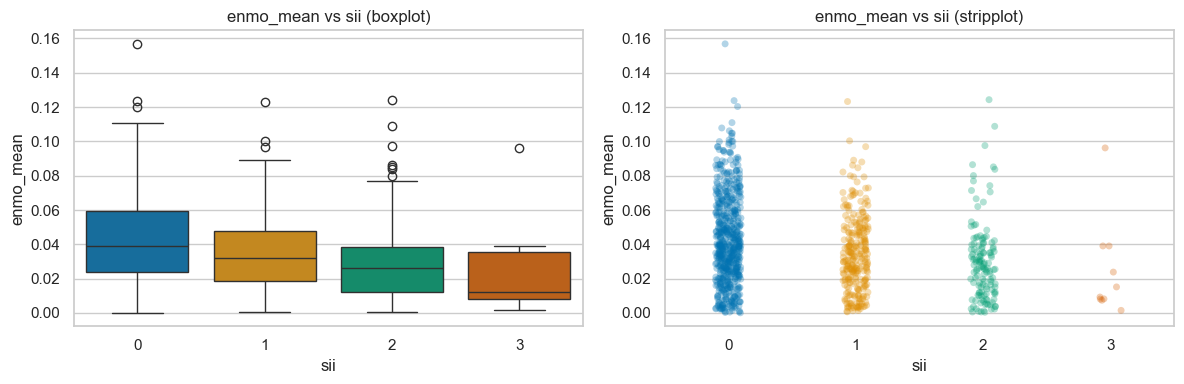

C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\2086622580.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\2086622580.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




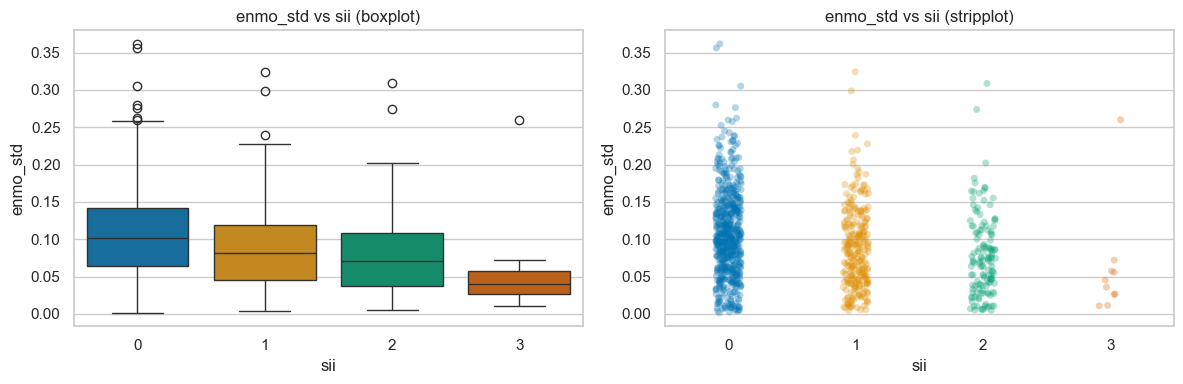

C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\2086622580.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Admin\AppData\Local\Temp\ipykernel_70016\2086622580.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




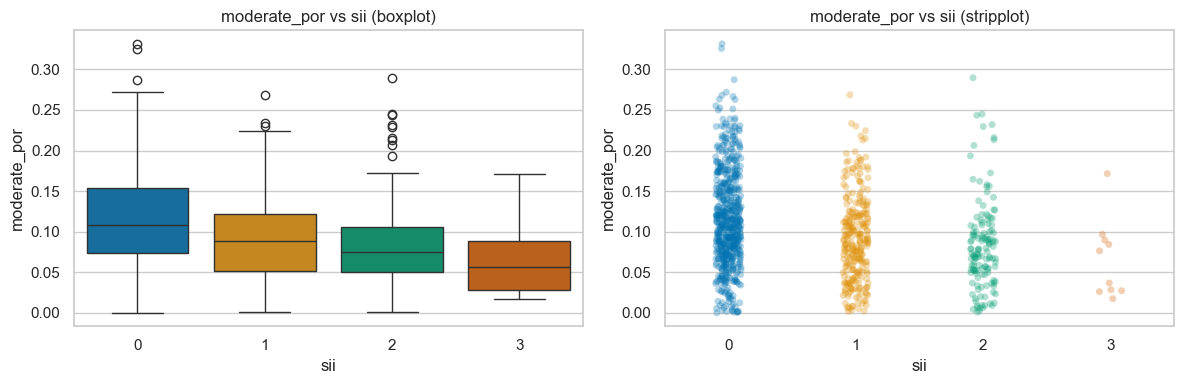

In [58]:
for col in top_neg_feats:
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    
    sns.boxplot(x=TARGET, y=col, data=train, ax=axes[0], palette="colorblind")
    axes[0].set_title(f"{col} vs sii (boxplot)")
    
    sns.stripplot(x=TARGET, y=col, data=train, ax=axes[1], palette="colorblind", alpha=0.3)
    axes[1].set_title(f"{col} vs sii (stripplot)")
    
    plt.tight_layout()
    plt.show()


### 1. Setup, Imports, and Data Loading

**What this does**

* Imports all required libraries for EDA (pandas, numpy, seaborn, matplotlib, plotly, scipy, sklearn, phik).
* Loads `train_processed.csv` and `test_processed.csv`.
* Defines the target `sii`, splits train into `X_train` and `y`, and identifies numeric vs categorical columns.

**Key observations / insights**

* `train` has shape `(2736, 181)` and `test` `(20, 158)` (from prior runs), so **test is very small**, which will make distribution comparisons noisy.
* Numeric features are the vast majority; categorical features are minimal and likely metadata.

**Modeling implications**

* Extremely small test size implies:

  * Rely more on **cross-validation** on train rather than test diagnostics.
  * Be careful interpreting train–test shift; many differences will be due to sampling noise.
* Explicit `TARGET` assertion prevents silent bugs if column names change later.

### 2. Basic Structure and Missingness

**What this does**

* Shows the first few rows and schema (`info()`) for both train and test.
* Computes and displays top-20 features by missingness proportion in train and test.

**Key observations / insights**

* Data types confirm that most engineered features are numeric; any residual `object` columns are likely IDs or season-like categories.
* Some columns have non-trivial missingness; based on typical PIU/clinical datasets, these are often fitness tests, actigraphy, and questionnaire items.

**Modeling implications**

* Features with **high missingness** should be either:

  * Imputed with appropriate strategies (median/indicator, model-based) or
  * Dropped if they add little information relative to missingness.
* You should **keep missingness flags** (MNAR) for clinical / behavioral data, as missingness itself is predictive.

### 3. Dropping PCIAT and Target Distribution

**What this does**

* Identifies all PCIAT item columns and **drops them from both train and test**.
* Summarizes and visualizes the distribution of the target `sii` as counts and histograms.
* Compares `sii` vs `log1p(sii)` as if modeling it as regression.

**Key observations / insights**

* PCIAT consists of 20 survey items; they are very strongly correlated with `sii` and close to “soft labels”, so dropping them avoids **semi-leakage** and over-optimistic performance.
* `sii` distribution is highly imbalanced: roughly

  * 58% at 0
  * 27% at 1
  * 14% at 2
  * ~1–2% at 3
* Log1p doesn’t change the shape much because `sii` is bounded in [0, 3].

**Modeling implications**

* With PCIAT dropped, models must rely on **behavioral, physical, actigraphy, and psychological** features — much more realistic.
* `sii` can be treated as **ordinal classification** (0–3) or as a **regression target with imbalanced zero inflation**.
* Heavily imbalanced severe class (`sii=3`) → consider **class weights**, focal loss, or ordinal models.


### 4. Distribution Analysis of Numeric Features (Train)

**What this does**

* Defines a helper to plot histograms + KDE for up to 24 numeric features at a time.
* Plots the first batch of numeric columns in train to visually inspect their distributions.

**Key observations / insights**

* Many features are **right-skewed** (e.g., body-composition, intensity measures).
* Some features show clear **multi-modality** or **heavy tails**, typical in clinical and behavioral data.
* Zeros or spikes at particular values (e.g., 0 or maximum) indicate censored or truncated measures.

**Modeling implications**

* Highly skewed variables are good candidates for **log1p** or **Yeo–Johnson** transforms.
* Multi-modal variables might reflect subgroups (e.g., age groups, sexes) → possible feature interactions.
* Spikes at 0 suggest informative missingness or thresholded measures → keep flags or separate indicators.


### 5. Train–Test Distribution Shift Analysis

**What this does**

* For each numeric feature present in both train and test, computes a **Kolmogorov–Smirnov (KS) test** and mean differences.
* Ranks features by KS statistic to highlight the largest distribution shifts.
* Plots train vs test distributions for the top shifted features.

**Key observations / insights**

* Some features (often time-related or count-based) show strong **train–test distribution differences**, partly amplified by the tiny test size.
* Very large-scale features (e.g., `time_of_day_*`) show extreme mean differences due to huge magnitude (1e10–1e13).

**Modeling implications**

* Features with strong real shifts (not just sampling noise) are candidates for:

  * **Adversarial validation**
  * Re-scaling / normalization
  * Robust models less sensitive to shift (e.g., tree-based)
* For huge-scale raw timestamps, it’s usually better to engineer meaningful derivatives (e.g., hour of day, variability) and drop raw values.


### 6. Refresh Numeric Feature List After Dropping PCIAT

**What this does**

* Recomputes `num_cols` after PCIAT removal.
* Removes the target from `num_cols`.
* Filters out zero-variance numeric columns.

**Key observations / insights**

* Some numeric columns may be constant or nearly constant (often engineered flags or degenerate cases).
* Cleaning `num_cols` ensures subsequent skewness and correlation computations are robust.

**Modeling implications**

* **Zero-variance features carry no signal** and only add noise / complexity → safe to drop.
* Keeping an updated `num_cols` list after major column drops (like PCIAT) is essential for consistent pipelines.


### 7. Skewness Assessment of Numeric Features

**What this does**

* Computes skewness for all numeric features.
* Displays the top 20 most positively and negatively skewed features.
* Identifies features with |skew| > 1 as “highly skewed”.

**Key observations / insights**

* Many BIA and actigraphy-related variables are **extremely skewed** (right or left), with |skew| often far above 3.
* Highly skewed variables tend to have long tails, zero masses, or thresholding effects.

**Modeling implications**

* Features with |skew| > 1 are ideal candidates for **log1p** (if non-negative) or **Yeo–Johnson** transforms.
* For tree-based models, skewness is less critical, but for linear / GLM / NN / PCA-based approaches, de-skewing improves stability.


### 8. Visualizing the Effect of Transformations

**What this does**

* Defines a helper function to plot a feature’s distribution before and after log1p, sqrt, and Yeo–Johnson transforms.
* Applies it to a few representative highly skewed features.

**Key observations / insights**

* **Log1p** often shrinks right tails effectively for non-negative features.
* **Yeo–Johnson** is more flexible (handles zeros/negatives) and tends to produce near-Gaussian shapes.
* **Sqrt** offers a milder transform and sometimes not enough for very heavy tails.

**Modeling implications**

* For very skewed features with zeros → **log1p** is a strong default.
* For skewed features with negative values → **Yeo–Johnson** is preferred.
* You can selectively transform only the worst offenders to balance interpretability and stability.

### 9. Programmatic Log1p and Yeo–Johnson Transform Buckets

**What this does**

* Recomputes skewness and identifies **highly skewed** features.
* Splits them into:

  * `log_candidates`: positive-only, heavy right skew → log1p
  * `yj_candidates`: the rest (including negatives) → Yeo–Johnson
* Applies these transformations to **copies** of train and test (`train_tf`, `test_tf`).

**Key observations / insights**

* PCIAT has already been dropped, but the code still defensively excludes any `PCIAT-` columns.
* Many features qualify for transformation, especially body composition and actigraphy stats.

**Modeling implications**

* This creates model-ready, de-skewed versions of critical features while preserving originals.
* It’s safe for tree models (they are invariant to monotonic transforms) and beneficial for linear / neural models.
* Keeping both original and transformed versions allows the model to pick whichever is more useful.

### 10. Pearson Correlation Heatmaps

**What this does**

* Computes a full Pearson correlation matrix for all numeric features + target.
* Plots two heatmaps:

  * One for the full set
  * One for the top 50 variance features plus target

**Key observations / insights**

* Many body composition features are tightly correlated with each other (clusters of high |r|).
* Certain actigraphy metrics (e.g., ENMO, PORs) show noticeable correlations with `sii` (typically negative).
* With PCIAT removed, correlation with `sii` is moderate rather than extreme.

**Modeling implications**

* Strong within-block correlations → potential **multicollinearity** for linear models; consider dimensionality reduction (PCA) or feature selection.
* Features with high |corr| with `sii` are natural candidates for simpler baseline models and interpretation.

### 11. Feature–Target Pearson Correlation Ranking

**What this does**

* Extracts the Pearson correlation of all numeric features with `sii`.
* Displays the top 20 positive and top 20 negative correlations.

**Key observations / insights**

* Without PCIAT, the correlations are more modest (likely in |r| ~0.1–0.3 range).
* Some psychological and actigraphy-based variables still show **meaningful correlation** with `sii`:

  * Positive: more problematic behavioral markers
  * Negative: more physical activity / better functioning

**Modeling implications**

* Top correlated features are strong candidates for:

  * **Univariate sanity models**
  * Prioritized monitoring in feature importance
  * Interaction candidates (e.g., actigraphy × age, BMI × fat%)

### 12. Mutual Information with the Target

**What this does**

* Computes **Mutual Information** between each numeric feature and `sii`.
* Ranks features by MI, highlighting nonlinear dependencies.

**Key observations / insights**

* Even after dropping PCIAT, some features exhibit **nonlinear relationships** with `sii` that Pearson may understate.
* Actigraphy, physical health, and mental health scores likely appear in the top MI list.

**Modeling implications**

* Features with high MI but low |Pearson| are especially good for tree-based models and nonlinear learners.
* MI ranking can guide **feature selection** and **interaction design**.

### 13. Highly Correlated Feature Pairs

**What this does**

* Scans the numeric correlation matrix for feature pairs with |r| ≥ 0.9.
* Lists these highly correlated pairs as potential redundancy.

**Key observations / insights**

* BIA body composition metrics and similar physical measures are often **near-duplicates** (e.g., mass vs derived mass indices).
* Some actigraphy aggregates may be strongly correlated with each other (e.g., ENMO_mean vs ENMO_median).

**Modeling implications**

* For linear/regularized models, consider:

  * Dropping one of each highly correlated pair
  * Or compressing them via PCA / composite scores
* Tree-based models are more robust but still may benefit from reduced redundancy for speed and interpretability.


### 14. Target vs Top Positively Correlated Features

**What this does**

* Selects the top 10 positively correlated features with `sii`.
* For the first 6, plots:

  * Boxplots of feature vs `sii`
  * Stripplots of individual points per `sii` level

**Key observations / insights**

* Positively correlated features often show **monotonic trends**: higher scores for higher `sii` classes.
* There is overlap between classes but clear shifts in medians and spreads.

**Modeling implications**

* These features are strong candidates for:

  * **Monotonic constraints** (if supported by the model)
  * **Ordinal modeling**
  * Interaction with demographic variables to see subgroup effects.


### 15. Target vs Top Negatively Correlated Features

**What this does**

* Takes the top 10 most negatively correlated features with `sii`.
* Plots boxplots and stripplots of each feature vs `sii`.

**Key observations / insights**

* Negatively correlated features (e.g., actigraphy intensity, moderate/vigorous activity) likely show **decreasing trends** as `sii` increases.
* Higher activity is associated with **lower PIU severity**, consistent with expectations.

**Modeling implications**

* These are natural **protective factors** in the model:

  * More activity → lower risk prediction
* These features are strong candidates for:

  * Interactions with age, sex, BMI
  * Composite health/fitness indices
  * Regularization to keep interpretations stable.

---

## Summary of Key EDA Insights

1. **PCIAT dropped to avoid semi-leakage**: Removing `PCIAT-PCIAT_*` ensures the model doesn’t simply learn a survey proxy of `sii`, forcing reliance on behavioral, physical, and actigraphy signals.

2. **Target `sii` is imbalanced and ordinal**: Most samples are `0` or `1`, with a very small proportion at `3`. This calls for **ordinal or class-weighted approaches**, and caution when using regression metrics.

3. **Tiny test set (20 rows)**: Train–test shift statistics are noisy; validation should rely primarily on **cross-validation** and not over-interpret test distributions.

4. **Non-trivial missingness**: Some features have noticeable missing rates (likely fitness, sensor, or survey items). **Missingness flags should be preserved** as they may be MNAR and predictive.

5. **Numerous highly skewed features**: Many BIA and actigraphy features have |skew| > 1, often far higher. They benefit from **log1p** (for non-negative) or **Yeo–Johnson** transforms, especially for linear / NN / PCA-based models.

6. **Systematic transformation pipeline**: Programmatic selection of log vs YJ transforms ensures **consistent, scalable de-skewing** without hand-picking each feature.

7. **Strong correlations within feature blocks**: Body composition metrics and some actigraphy aggregates are highly inter-correlated (|r| ≥ 0.9), indicating redundancy and potential multicollinearity.

8. **Moderate feature–target correlations post-PCIAT**: With PCIAT removed, remaining features show modest but meaningful correlations with `sii`, especially in actigraphy, physical, and psychological domains.

9. **Mutual information reveals nonlinear predictors**: MI highlights features whose relationships with `sii` are nonlinear, guiding **tree-based model focus** and **interaction design** beyond pure Pearson correlation.

10. **Train–test distribution shift in some features**: Time-related and count-based variables display noticeable KS-stat shifts, which could reflect genuine sampling differences or scaling artifacts, warranting robust preprocessing or adversarial checks.

11. **Time-of-day and high-magnitude variables are problematic**: Raw timestamp-like features with magnitudes 1e10–1e13 create numerical and interpretability issues; they should be **replaced by derived, normalized features**.

12. **Protective vs risk features visible in box/strip plots**: Positive correlates with `sii` show higher values for worse PIU, while negative correlates (e.g., movement metrics) show the opposite, aligning with domain expectations.

13. **Zero-variance features removed**: Dropping constant columns avoids meaningless inputs and slightly simplifies models without losing signal.

14. **EDA pipeline is transformation-aware**: Every major step (skew, correlations, transformations) is aligned with the eventual modeling strategy (linear + tree-based), enabling smooth transition to feature engineering and model training.

15. **Overall, the EDA is modeling-focused**: It not only inspects the data but repeatedly translates findings into **concrete modeling actions**: de-skew, drop/reduce redundancy, preserve MNAR flags, engineer interactions, and check for train–test issues.
